cargar las señales

In [155]:
import wfdb
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
import pandas as pd
from scipy.signal import butter, filtfilt

In [156]:
#limpiar carpeta de archivos
def limpiar_carpeta(carpeta):
    for file in os.listdir(carpeta):
        os.remove(carpeta+'/'+file)

#limpiar_carpeta('data/dirty')

Primero se leen las caracteristicas de las señales y se importa la misma.

In [157]:
def get_name_files(path,type):
    files = []
    for file in os.listdir(path):
        if file.endswith(type):
            files.append(file[:-4])
    return files

def read_file_hea(filename, path):
    # lee archivo .hea
    record = wfdb.rdheader(path+filename)
    return record

def read_file_mat(file, path):
    # carga archivo .mat (tiene las señales)
    mat_data = loadmat(path + file +'.mat')
    signals = mat_data['val']

    # imprimir flat areas y zigzag areas

    return signals
def read_file_flat(file,path):
    mat_data = loadmat(path + file +'.mat')
    flatareas = mat_data['flatareas']
    return flatareas
def read_file_zigzag(file,path):
    mat_data = loadmat(path + file +'.mat')
    zigzagareas = mat_data['zigzagareas']
    return zigzagareas

In [158]:
#función para graficar una cantidad de señales general y la guarde en jpg
def grafica_ecg(record, signals, path_save,picos_r=None):
    #grafica las señales ecg
    plt.figure(figsize=(12, 6))
    for i in range(len(record.sig_name)):
        plt.subplot(len(record.sig_name), 1, i+1)
        plt.plot(signals[i, :], label=f'Señal: {record.sig_name[i]}')
        if picos_r is not None:
            plt.plot(picos_r, signals[i, picos_r], 'ro', markersize=1)
            #Imprime los picos_r
            print(f'Picos R señal {record.sig_name[i]}: {picos_r}')

        plt.xlabel('Muestras')
        plt.ylabel(record.units[i])
        plt.legend()
    #agregar comentarios
    plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
    # genera jpg
    plt.savefig(path_save + record.record_name + '.jpg')
    plt.close()

def graf_signals(files, path, cant, path_save):
    for fileName in files[:cant]:
        print('Graficando señales de: ', fileName)
        record = read_file_hea(fileName, 'data/training/')
        signals, flat_areas, zigzag_areas = read_file_mat(fileName, path) 
        #picos_r = sio.loadmat(path +file+'.mat')['picos_r']
        grafica_ecg(record,signals, path_save)

def grafica_preview(record, signals, oldSignal, path, flat_areas=[], zigzag_areas=[]):
    oldSignal = oldSignal[:, -record.fs*10:]
    plt.figure(figsize=(12, 6))
    for i in range(signals.shape[0]):
        plt.subplot(signals.shape[0], 1, i + 1)
        plt.plot(signals[i, :], label=f'Señal limpia: {record.sig_name[i]}', color='blue', alpha=0.5)
        plt.plot(oldSignal[i, :], label=f'Señal original: {record.sig_name[i]}', color='red', alpha=0.3)
        # Resaltar visualmente los segmentos planos si existen

        print(flat_areas)
        print(zigzag_areas)

        if  flat_areas.size > 0:
            for flat in flat_areas[0,i]:
                plt.axvspan(flat[0], flat[1], color='red', alpha=0.5)

        # Resaltar visualmente los segmentos zigzag si existen
        if zigzag_areas.size > 0:
            for zigzag in zigzag_areas[0,i]:
                plt.axvspan(zigzag[0], zigzag[1], color='yellow', alpha=0.5)
        
        plt.xlabel('Muestras')
        plt.ylabel(record.units[i])
        plt.legend()

    plt.suptitle(record.comments[0] + ' - ' + record.comments[1])
    plt.show()



Se observan las características de los archivos.

In [159]:
# path de los archivos iniciales
old_path='data/training/'
#toma los nombres de los archivos .hea
nameFiles = get_name_files(old_path,'.hea')
#revisa el primer archivo .hea
heaRecord1 = read_file_hea(nameFiles[0], old_path)
print(heaRecord1.__dict__)

{'record_name': 'a103l', 'n_sig': 3, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 82500, 'base_time': None, 'base_date': None, 'comments': ['Asystole', 'False alarm'], 'sig_name': ['II', 'V', 'PLETH'], 'p_signal': None, 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['a103l.mat', 'a103l.mat', 'a103l.mat'], 'fmt': ['16', '16', '16'], 'samps_per_frame': [1, 1, 1], 'skew': [None, None, None], 'byte_offset': [24, 24, 24], 'adc_gain': [7247.0, 10520.0, 12530.0], 'baseline': [0, 0, 0], 'units': ['mV', 'mV', 'NU'], 'adc_res': [16, 16, 16], 'adc_zero': [0, 0, 0], 'init_value': [-171, 9127, 6042], 'checksum': [-27403, -301, -17391], 'block_size': [0, 0, 0]}


In [160]:
all_unique_sig_names = set()
for file in nameFiles:
    record = read_file_hea(file, old_path)
    all_unique_sig_names.update(record.sig_name)

print(f"All unique signal names across all files: {all_unique_sig_names}")
print(f"Total number of unique signal names: {len(all_unique_sig_names)}")

All unique signal names across all files: {'ABP', 'aVR', 'V', 'MCL', 'II', 'I', 'RESP', 'III', 'PLETH', 'aVF', 'aVL'}
Total number of unique signal names: 11


# Análisis de calidad y eliminación de la desviación de la línea base. 
Para el análisis de calidad, se verificó la presencia de líneas planas y líneas en zigzag en las señales.

Las líneas planas o en zigzag son segmentos de señales que tienen
una actividad eléctrica casi nula. Los segmentos de señal que tienen
una diferencia de amplitud cero entre dos muestras consecutivas,
durante un mínimo de dos segundos, se clasificaron como "líneas
planas". Los segmentos de señal que tienen pendientes positivas y
negativas alternas entre dos muestras sucesivas, durante un mínimo
de segundos, se clasificaron como líneas en zigzag.


Para la eliminación de la desviación de la línea base se aplicó un filtro de paso bajo Butterworth bidireccional de segundo orden con una frecuencia de corte de 1 Hz a las señales
del ECG.

## Proceso para identificar segmentos zigzag (pendiente aún):
Cálculo de la pendiente: Evaluamos la diferencia entre muestras consecutivas para obtener la pendiente. Una pendiente positiva se da cuando el valor aumenta, y una negativa cuando el valor disminuye.

Alternancia de signos: Un zigzag ocurre cuando la pendiente cambia de signo (de positiva a negativa o viceversa).

Duración mínima: Controlamos que la alternancia ocurra durante un número mínimo de segundos, es decir, durante un número determinado de muestras consecutivas.

In [161]:

# filtro butterworth
def butter_bandpass_filter(data, cutoff=1, fs=250, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(ecg_signal, lowcut=0.5, highcut=50.0, fs=250, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_signal = filtfilt(b, a, ecg_signal)
    return filtered_signal

#marcas
def mark_flat_lines(signal, fs=250, min_duration=0.3, flat_value=-9999, threshold=7):
    """
    Marca líneas planas en la señal donde la diferencia entre valores consecutivos es menor que un umbral.

    Parameters:
    - signal: La señal a analizar (ECG o PPG).
    - fs: Frecuencia de muestreo en Hz.
    - min_duration: Duración mínima en segundos para que se considere una línea plana.
    - flat_value: El valor que se utilizará para marcar las líneas planas en la señal.
    - threshold: Umbral de diferencia entre muestras consecutivas para considerar una línea plana.
    
    Returns:
    - marked_signal: La señal con las líneas planas marcadas.
    - flat_areas: Lista de tuplas (inicio, fin) que indican las áreas planas detectadas.
    """
    # Número de muestras consecutivas que definen una línea plana
    min_samples = int(min_duration * fs)

    # Diferencias absolutas entre muestras consecutivas
    diff_signal = np.abs(np.diff(signal))

    # Encuentra dónde la diferencia es menor que el umbral
    flat_segments = (diff_signal < threshold).astype(int)

    # Identifica segmentos planos continuos de al menos min_samples de duración
    flat_areas = []
    current_length = 0
    start_index = None

    for i in range(len(flat_segments)):
        if flat_segments[i] == 1:  # Si es un segmento plano
            if current_length == 0:
                start_index = i
            current_length += 1
        else:
            if current_length >= min_samples:  # Si cumple con la duración mínima
                flat_areas.append((start_index, start_index + current_length))
            current_length = 0

    # Considerar el último segmento si termina en una zona plana
    if current_length >= min_samples:
        flat_areas.append((start_index, start_index + current_length))

    # Marca los segmentos planos en la señal
    marked_signal = np.copy(signal)
    for start, end in flat_areas:
        marked_signal[start:end] = flat_value  # Marcar con un valor específico como -9999
    
    return marked_signal, flat_areas

def mark_zigzag_lines(signal, fs=250, min_duration=0.3):
    """
    Identifica segmentos en zigzag en una señal.
    
    Parámetros:
    signal (numpy array): La señal a analizar.
    fs (int): Frecuencia de muestreo en Hz. Por defecto es 250 Hz.
    min_duration (float): Duración mínima en segundos de un zigzag. Por defecto es 0.2 segundos.
    
    Retorna:
    zigzag_areas (list): Lista de tuplas (inicio, fin) de los segmentos en zigzag.
    """
    # Número de muestras consecutivas que definen un zigzag
    min_samples = int(min_duration * fs)
    
    # Calcula las diferencias entre muestras consecutivas (pendiente)
    diff_signal = np.diff(signal)
    
    # Determina si la pendiente es positiva o negativa
    sign_changes = np.sign(diff_signal)
    
    # Identifica los cambios de signo consecutivos (zigzag)
    zigzag_segments = (sign_changes[:-1] * sign_changes[1:] == -1).astype(int)

    # Identifica segmentos zigzag continuos de al menos min_samples de duración
    zigzag_areas = []
    current_length = 0
    start_index = None
    
    for i in range(len(zigzag_segments)):
        if zigzag_segments[i] == 1:  # Cambio de pendiente
            if current_length == 0:
                start_index = i
            current_length += 1
        else:
            if current_length >= min_samples:
                zigzag_areas.append((start_index, start_index + current_length + 1))
            current_length = 0

    # Último segmento
    if current_length >= min_samples:
        zigzag_areas.append((start_index, start_index + current_length + 1))
    
    return zigzag_areas


In [162]:
new_path = 'data/cleaned/'
dirty_path = 'data/dirty/'

if not os.path.exists(new_path):
    os.makedirs(new_path)

# Se limpian todas las señales y se dejan en el nuevo directorio
for fileName in nameFiles:
    path = old_path
    record = read_file_hea(fileName, path)
    signals = read_file_mat(fileName, path)

    # Recorta y deja sólo los últimos 10 segundos de señal
    signals = signals[:, -record.fs*10:]

    # Guarda las señales sucias en un archivo .mat para ver cómo quedaron
    sio.savemat(dirty_path + fileName + '.mat', {'val': signals})

    # Se aplica filtro butterworth de paso de banda sólo a las señales ECG ('I', 'II', 'III' y 'V')
    ecg = ['I', 'II', 'III', 'V']
    flat_areas_all = []
    zigzag_areas_all = []

    for i in range(len(record.sig_name)):
        flat_signal, flat_areas0 = mark_flat_lines(signals[i, :], fs=record.fs)
        zigzag_areas0 = mark_zigzag_lines(signals[i, :], fs=record.fs)

        flat_areas_all.append(flat_areas0)
        zigzag_areas_all.append(zigzag_areas0)  
        print('flat areas:', flat_areas_all)
        print('zigzag areas: ', zigzag_areas_all)

        if record.sig_name[i] in ecg:
            channel = signals[i, :]
            filtered = butter_bandpass_filter(channel)
            cleanedChannel = channel - filtered
            signals[i, :] = cleanedChannel

    # Guarda las señales limpias y las áreas en un archivo .mat


    print('flat areas2: ',flat_areas_all)
    sio.savemat(new_path + fileName + '.mat', {
        'val': signals,
        'flatareas' : flat_areas_all,
        'zigzagareas': zigzag_areas_all
    })


flat areas: [[]]
zigzag areas:  [[]]
flat areas: [[], []]
zigzag areas:  [[], []]
flat areas: [[], [], []]
zigzag areas:  [[], [], []]
flat areas2:  [[], [], []]
flat areas: [[(562, 672), (796, 906)]]
zigzag areas:  [[(562, 674), (796, 908)]]
flat areas: [[(562, 672), (796, 906)], []]
zigzag areas:  [[(562, 674), (796, 908)], []]
flat areas: [[(562, 672), (796, 906)], [], []]
zigzag areas:  [[(562, 674), (796, 908)], [], []]
flat areas2:  [[(562, 672), (796, 906)], [], []]
flat areas: [[]]
zigzag areas:  [[]]
flat areas: [[], []]
zigzag areas:  [[], []]
flat areas: [[], [], []]
zigzag areas:  [[], [], []]
flat areas2:  [[], [], []]
flat areas: [[]]
zigzag areas:  [[]]
flat areas: [[], []]
zigzag areas:  [[], []]
flat areas: [[], [], []]
zigzag areas:  [[], [], []]
flat areas: [[], [], [], [(830, 1162), (1343, 1565), (1818, 1946), (2058, 2306), (2406, 2499)]]
zigzag areas:  [[], [], [], [(828, 1163), (1816, 1948), (2404, 2499)]]
flat areas2:  [[], [], [], [(830, 1162), (1343, 1565), (18

In [163]:
# prueba abrir áresas planas y zigzag
examplefile= nameFiles.index('v775l') #nombre de la muestra
example = read_file_mat(nameFiles[examplefile],new_path)
exflat= read_file_flat(nameFiles[examplefile],new_path)
print(exflat)
print(exflat[0,0])
print(example)


[[array([[  90,  168],
         [1236, 1334]]) array([[1798, 1908]])
  array([], shape=(0, 0), dtype=float64)]]
[[  90  168]
 [1236 1334]]
[[ 591  576  822 ...  525  593  405]
 [-432 -442 -422 ... -227 -308 -211]
 [4942 4889 4847 ... 2254 2249 2239]]


# Probando filtros

[[array([[   0, 2499]]) array([[   0, 2499]])
  array([], shape=(0, 0), dtype=float64) array([[   0, 2499]])]]
[]
[[array([[   0, 2499]]) array([[   0, 2499]])
  array([], shape=(0, 0), dtype=float64) array([[   0, 2499]])]]
[]
[[array([[   0, 2499]]) array([[   0, 2499]])
  array([], shape=(0, 0), dtype=float64) array([[   0, 2499]])]]
[]
[[array([[   0, 2499]]) array([[   0, 2499]])
  array([], shape=(0, 0), dtype=float64) array([[   0, 2499]])]]
[]


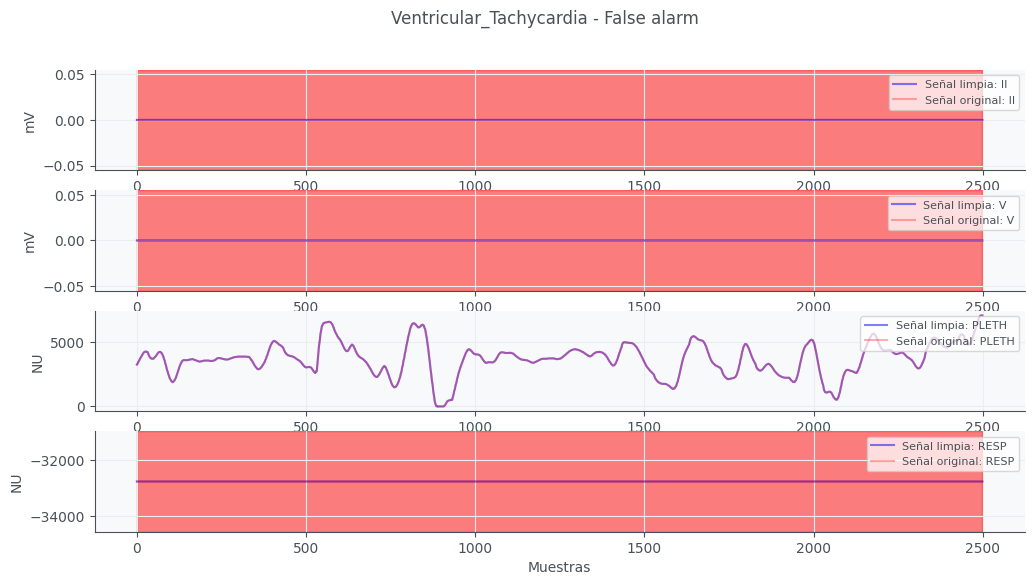

In [164]:
# grafica una señal limpia preview
nameFile = nameFiles.index('v774s') #nombre de la muestra
record = read_file_hea(nameFiles[nameFile], old_path) #buscar . hea siempre será en old_path
signalPreview = read_file_mat(nameFiles[nameFile], new_path)
oldSignal = read_file_mat(nameFiles[nameFile], old_path)
flat_areas = read_file_flat(nameFiles[nameFile], new_path)
zigzag_areas = read_file_zigzag(nameFiles[nameFile], new_path)


grafica_preview(record, signalPreview, oldSignal, new_path, flat_areas, zigzag_areas)



guarda los gráficos de la señal sin procesar en un directorio para analizarla de forma visual

# División de los datos de entrenamiento
Ahora vamos a seleccionar los datos de entrenamiento y los de testeo, para cada tipo de señal.